In [40]:
import obspy
import matplotlib.pyplot as plt
import os
import random
from scipy.signal import resample
import numpy as np
import pandas as pd
import itertools
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, Callback
from model_utils import Params, DAT_normalize, DAT_filter, get_wav
from model_utils import save_dict_to_json
!pip install -e .
from ArrNet import ArrNet

distutils: /home/dickey/anaconda3/envs/aiml/include/python3.8/UNKNOWN
sysconfig: /home/dickey/anaconda3/envs/aiml/include/python3.8
user = False
home = None
root = None
prefix = None
Obtaining file:///media/HDD2/PycharmProjects/CodaMag
  Attempting uninstall: sdea
    Found existing installation: sdea 0.0.0
    Uninstalling sdea-0.0.0:
      Successfully uninstalled sdea-0.0.0
  Running setup.py develop for sdea
distutils: /home/dickey/anaconda3/envs/aiml/include/python3.8/UNKNOWN
sysconfig: /home/dickey/anaconda3/envs/aiml/include/python3.8
user = False
home = None
root = None
prefix = None


In [41]:
def extract_env(st, samprate=1.0):
    orig_data = st[0].data
    orig_num_samps = len(orig_data)
    orig_samprate = st[0].stats.sampling_rate
    if st[0].stats.sac['f'] > 0:
        fini_sec = st[0].stats.sac['f'] - st[0].stats.sac['b']
    else:
        fini_sec = 0
    
    num_samps = int((orig_num_samps / orig_samprate) * samprate)
    data = resample(orig_data, num_samps)
    data = data - data.mean()
    data = data / np.std(data)
    fini = int(fini_sec * samprate)
    begi = int(- st[0].stats.sac['b'] * samprate)
    
    return data, begi, fini

def plot_env(st, ax):
    ax.plot(st[0].data)
    ax.axvline(-st[0].stats.sac['b'] * st[0].stats.sampling_rate, color='green')
    ax.axvline((-st[0].stats.sac['b'] + st[0].stats.sac['e']) * st[0].stats.sampling_rate, color='red')
    ax.axvline((st[0].stats.sac['f']-st[0].stats.sac['b']) * st[0].stats.sampling_rate, color='blue')
    ax.set_title(f'{st[0].stats.sampling_rate} Hz / {st[0].stats.npts} samples')
    
def plot_env(d, b, f, ax):
    ax.plot(d)
    ax.axvline(b)
    ax.axvline(f, color='red')
    ax.set_title(f'{len(d)} samples')
    
def explore_env_dir(env_dir, num_envs=10):
    envelope_files = os.listdir(env_dir)

    fig, ax = plt.subplots(num_envs,1, figsize=(15, num_envs))
    for i in range(num_envs):
        try:
            my_env = obspy.read(os.path.join(env_dir, random.choice(envelope_files)))
            d, b, f = extract_env(my_env)
            plot_env(d, b, f, ax[i])
        except:
            pass
         
    fig.suptitle(f'{env_dir}\n{len(envelope_files)} envelopes')
    fig.savefig(f'{env_dir.split("/")[1]}.png')
    

In [3]:
evnelope_directories = ['data/Amatrice_Broad_Area/Envelopes_39_Kevin/',
                        'data/Bay_Area_CCT_Example/Envelope_stack_Kevin_picks/',
                        'data/Eastern_Canada/Envelopes_Kevin/',
                        'data/Utah_update/Envelopes_Kevin1',
                        'data/PR_CCT/Final_Envelopes/']

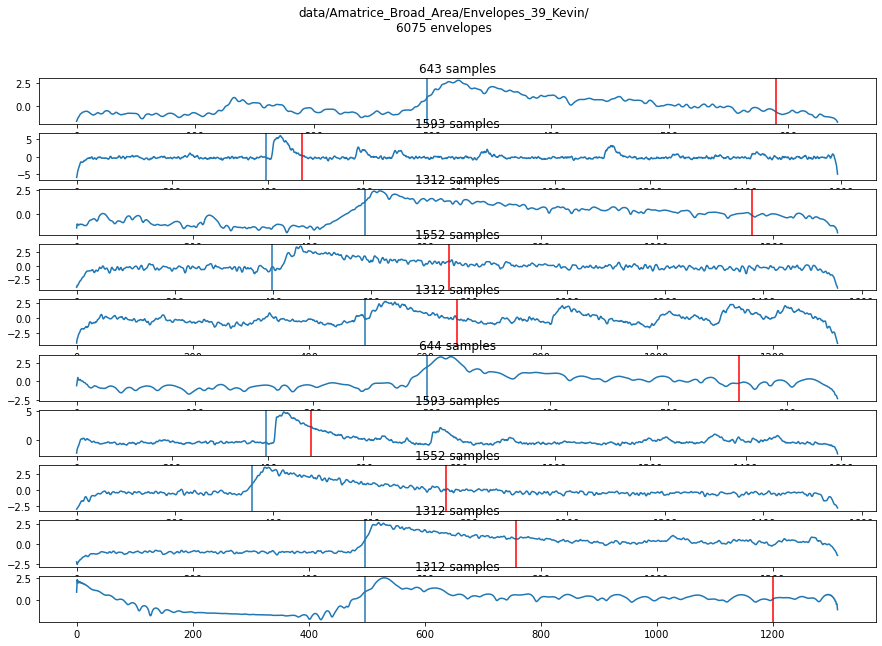

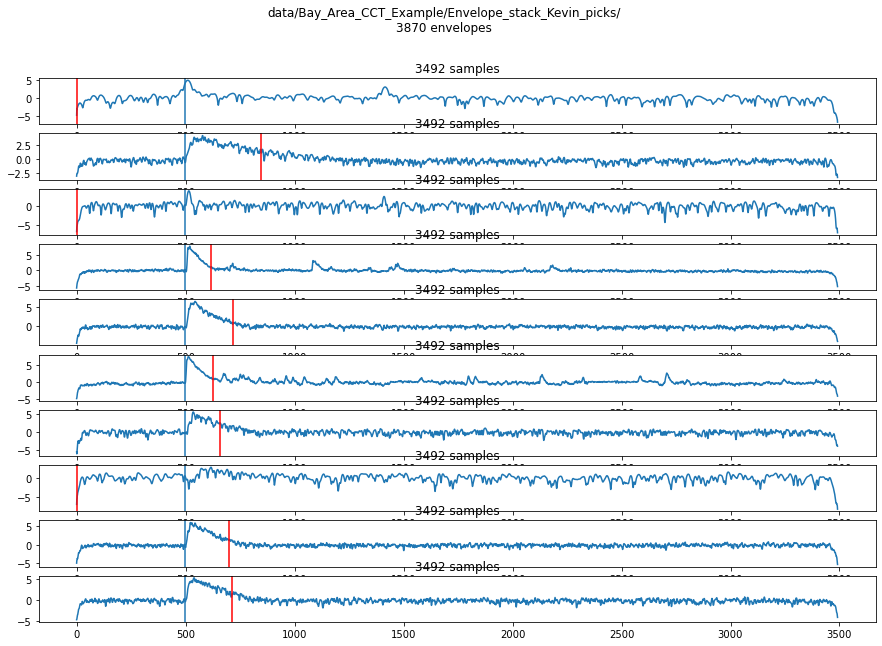

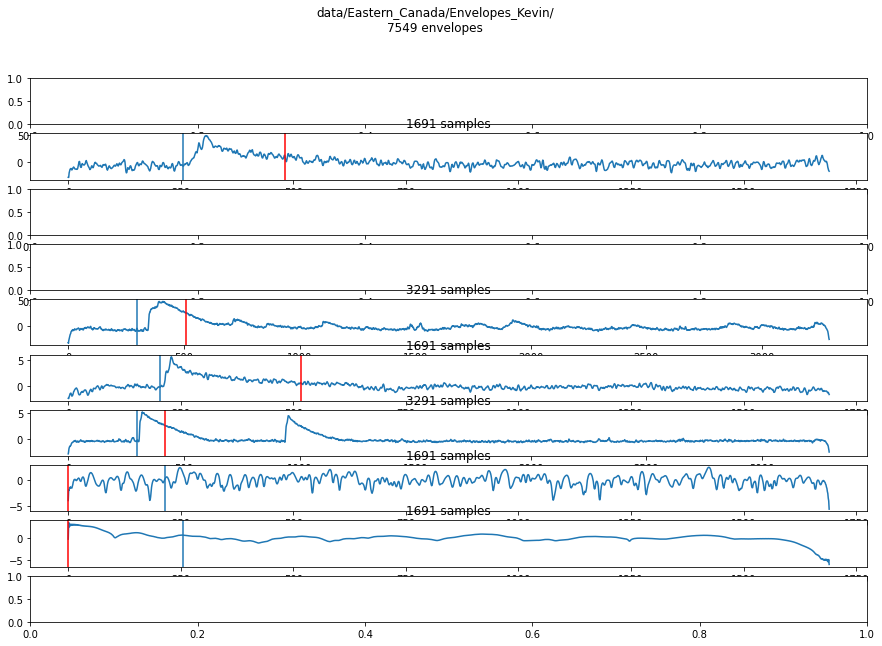

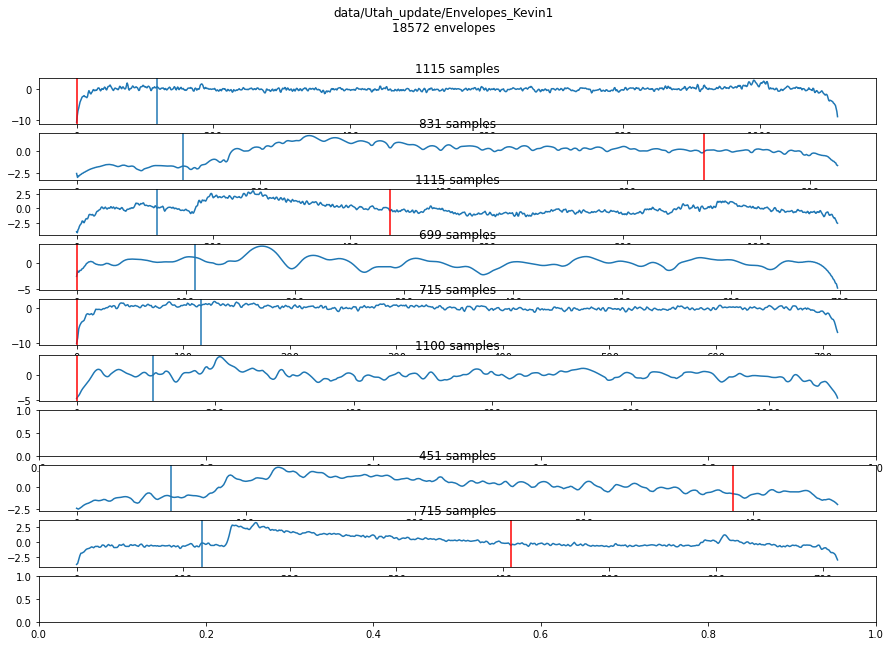

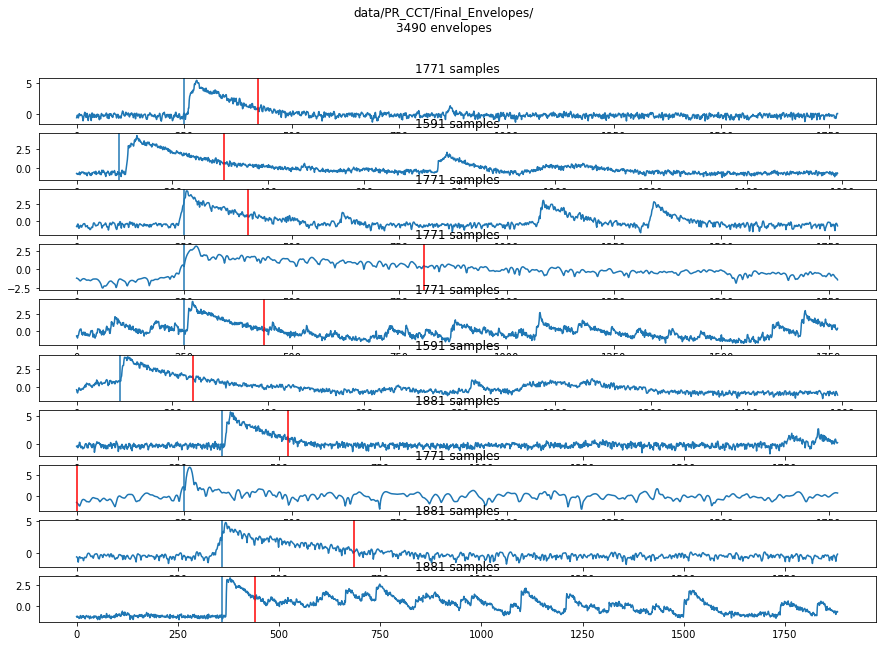

In [4]:
for env_dir in evnelope_directories:
    explore_env_dir(env_dir)

In [66]:
data = []
metadata = []
for env_dir in evnelope_directories:
    envelope_files = os.listdir(env_dir)
    for env_file in envelope_files:
        try:
            my_env = obspy.read(os.path.join(env_dir, env_file))
            my_orig_samprate = my_env[0].stats.sampling_rate
            my_region = env_dir.split('/')[1]
            my_station = my_env[0].stats.station
            my_network = my_env[0].stats.network
            my_time = my_env[0].stats.starttime.strftime("%Y-%m-%d %H:%M:%S")
            my_data, my_begin, my_finish = extract_env(my_env)

            data.append(my_data)
            metadata.append([my_network, my_station, my_time, my_begin, my_finish, len(my_data), my_orig_samprate, env_dir+env_file, my_region])
        except:
            pass
        
df = pd.DataFrame(metadata, columns=['network', 'station', 'time', 'begin', 'finish', 'length', 'orig_samprate', 'file', 'region'])
data = np.column_stack((itertools.zip_longest(*data, fillvalue=0)))
        
df.to_pickle('coda_cat.gz')
np.save('coda_dat.npz', data)

<ipython-input-66-f70f41c4644c>:21: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  data = np.column_stack((itertools.zip_longest(*data, fillvalue=0)))


In [61]:
cat = pd.read_pickle('coda_cat.gz')
dat = np.load('coda_dat.npy').astype(np.float32)

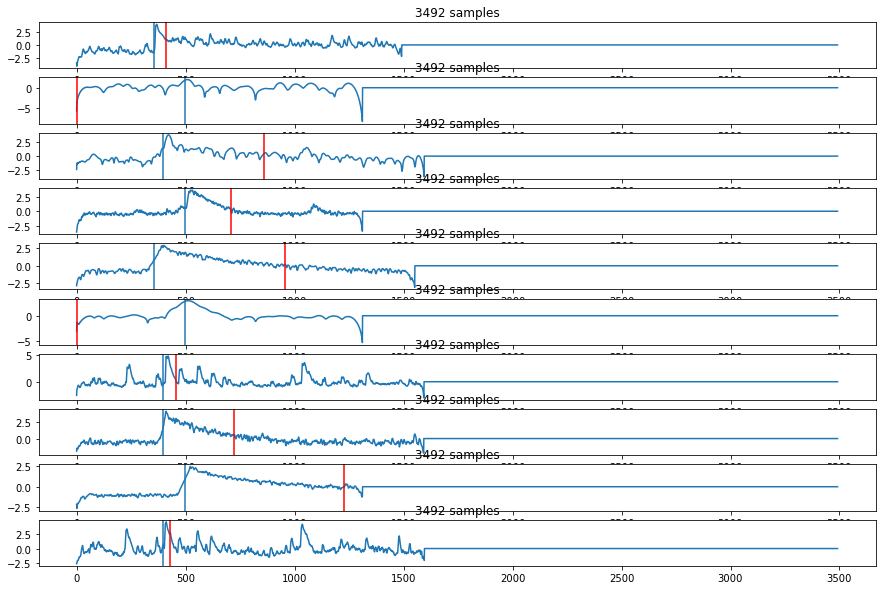

In [62]:
num_envs=10
fig, ax = plt.subplots(num_envs,1, figsize=(15, num_envs))
for i in range(num_envs):
    my_meta = cat.iloc[i]
    my_data = dat[i]
    plot_env(my_data, my_meta.begin, my_meta.finish, ax[i])
    

In [63]:
my_cat = cat[(cat.length > 1500) & 
             (cat.finish > 0) &
             (cat.begin > 100) &
             (cat.finish < 1400)]

my_dat = dat[my_cat.index, :1500]

my_cat.reset_index(drop=True, inplace=True)

In [64]:
my_cat

network station                 time  begin  finish  length  \
0          IV    INTR  2009-04-09 04:26:07    397     859    1595   
1          IV    FIAM  2016-11-03 00:29:03    357     958    1552   
2          IV    INTR  2009-04-09 04:26:07    397     458    1594   
3          IV    TERO  2009-04-09 03:08:14    397     724    1593   
4          IV    FIAM  2009-04-09 04:26:07    398     428    1596   
...       ...     ...                  ...    ...     ...     ...   
11035      PR    OBIP  2020-04-07 12:54:35    359     495    1881   
11036      PR    EMPR  2019-05-02 01:06:16    250     364    1771   
11037      PR    CELP  2020-01-03 03:35:15    360     531    1881   
11038      PR    HUMP  2020-01-02 20:37:52    249     394    1771   
11039      PR    OBIP  2020-01-18 23:59:55    360     512    1881   

       orig_samprate                                               file  \
0                4.0  data/Amatrice_Broad_Area/Envelopes_39_Kevin/IN...   
1                4.0  data/Amatrice_Broad_Area/Envelopes_39_Kevin/FI...   
2               40.0  data/Amatrice_Broad_Area/Envelopes_39_Kevin/IN...   
3                4.0  data/Amatrice_Broad_Area/Envelopes_39_Kevin/TE...   
4               40.0  data/Amatrice_Broad_Area/Envelopes_39_Kevin/FI...   
...              ...                                                ...   
11035            1.0  data/PR_CCT/Final_Envelopes/OBIP_STACK_1586264...   
11036            1.0  data/PR_CCT/Final_Envelopes/EMPR_STACK_1556759...   
11037            1.0  data/PR_CCT/Final_Envelopes/CELP_STACK_1578022...   
11038            1.0  data/PR_CCT/Final_Envelopes/HUMP_STACK_1577997...   
11039            1.0  data/PR_CCT/Final_Envelopes/OBIP_STACK_1580256...   

                    region  
0      Amatrice_Broad_Area  
1      Amatrice_Broad_Area  
2      Amatrice_Broad_Area  
3      Amatrice_Broad_Area  
4      Amatrice_Broad_Area  
...                    ...  
11035               PR_CCT  
11036               PR_CCT  
11037               PR_CCT  
11038               PR_CCT  
11039               PR_CCT  

[11040 rows x 9 columns]

In [65]:
my_dat.shape

(11040, 1500)

In [66]:
tst_cat = my_cat[my_cat.time > '2020']
trn_cat = my_cat[my_cat.time < '2020']
tst_dat = my_dat[tst_cat.index, 50:-50]
trn_dat = my_dat[trn_cat.index]
tst_cat.reset_index(drop=True, inplace=True)
trn_cat.reset_index(drop=True, inplace=True)

In [101]:
# Call the get_default_par method to save a set of default parameters in a json file.
# All hyperparameters for the network are controlled by setting values in this par file.

params = ArrNet.get_default_par(os.path.join('.', 'test_par.json'))

if not os.path.exists(params.model_folder):
    os.mkdir(params.model_folder)
if not os.path.exists(params.log_folder):
    os.mkdir(params.log_folder)
if not os.path.exists(params.data_folder):
    os.mkdir(params.data_folder)    
if not os.path.exists(params.image_folder):
    os.mkdir(params.image_folder) 
    
params.bs = 64
params.s_rate = 1
params.w_len = 1400
params.shift = 50
params.d = [2,4,8,32,64]
params.dense = [64,64]
params.pat = 20
params.s = 6
params

lr             : 0.001
bs             : 64
loss           : quantile
optimizer      : adam
f_low          : 0.8
f_high         : 4.5
f_pad          : 3
cmpts          : Z
s_rate         : 1
w_len          : 1400
shift          : 50
f              : 45
d              : [2, 4, 8, 32, 64]
k              : 20
s              : 3
dense          : [64, 64]
pat            : 20
t_step         : 64
v_step         : 64
cmps           : B
zp             : False
project_name   : 
model_name     : lr:0.001|bs:32|loss:quantile|optimizer:adam|f_low:0.8|f_high:4.5|f_pad:3|cmpts:Z|s_rate:40|w_len:30|shift:5|f:45|d:2x4x8x16x32|k:20|s:3|dense:64x64|pat:20|t_step:64|v_step:64|cmps:B|zp:False|trnRET:False|type:tcn|quantiles:0.9772x0.8413x0.1538x0.0228
model_file     : 
model_save     : 
log_folder     : logs/
data_folder    : data/
image_folder   : images/
model_folder   : models/
trnRET         : False
catalog        : 
type           : tcn
quantiles      : [0.9772, 0.8413, 0.1538, 0.0228]



In [102]:
def gen(cat, dat, pdict, val=False):
    
    bs = pdict.bs
    w_len_samps = int(pdict.s_rate * pdict.w_len)
    nb_chans = 1
    
    while 1:
        random.seed()
        X = np.zeros((bs, w_len_samps, nb_chans))
        Y = np.ones((bs, 1))
        shift = np.random.randint(low=0, high=pdict.shift, size=(bs))
        df = pd.DataFrame() 
        
        batch_counter = 0

        while batch_counter < bs:
            
            try:
                index = random.randint(0,len(cat))
                rec = cat.iloc[index]
                Y[batch_counter] = rec.finish - shift[batch_counter]
                X[batch_counter,:,0] = dat[index, shift[batch_counter]:shift[batch_counter]+w_len_samps]
                batch_counter += 1
                if val: df = df.append(rec)
            except:
                pass

        if val: yield X, Y, df
        else:   yield X, Y


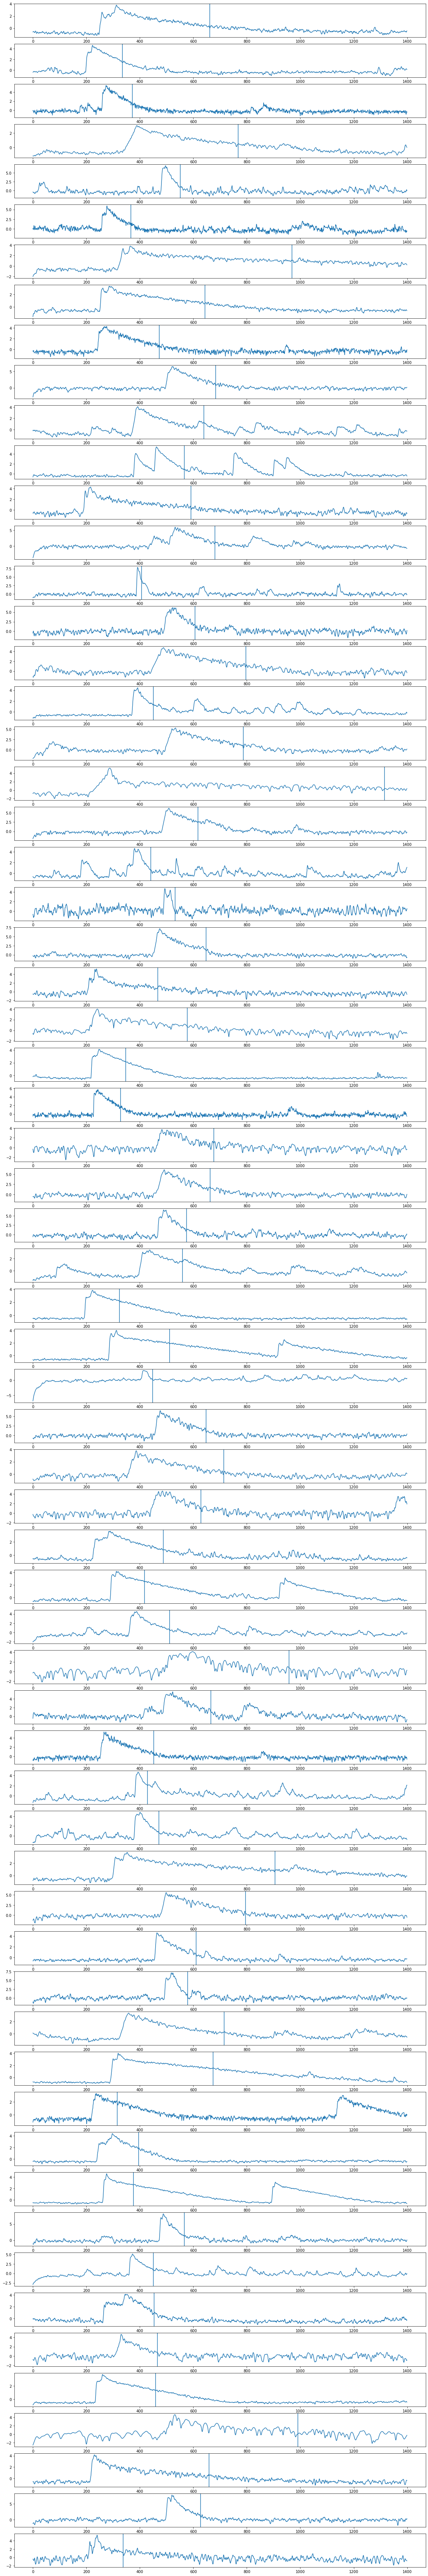

In [103]:
trn_gen = gen(trn_cat, trn_dat, params)

# plot some waveforms 
X, Y = next(trn_gen)

nb_plot = params.bs
fig, ax = plt.subplots(nb_plot, 1, figsize=(20,nb_plot*2))
for i in range(nb_plot):
    ax[i].plot(X[i])
    ax[i].axvline((Y[i]))

In [104]:
model = ArrNet.get_network(params)
model.summary()

Model: "q_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_210 (Conv1D)             (None, None, 45)     945         input_9[0][0]                    
__________________________________________________________________________________________________
activation_105 (Activation)     (None, None, 45)     0           conv1d_210[0][0]                 
__________________________________________________________________________________________________
spatial_dropout1d_105 (SpatialD (None, None, 45)     0           activation_105[0][0]             
____________________________________________________________________________________________

In [105]:
def get_callbacks(pdict):
    tensor_foldername = os.path.join(pdict.log_folder, pdict.model_name)
    if not os.path.exists(tensor_foldername):
        os.mkdir(tensor_foldername) 
    model_filename = os.path.join(pdict.model_folder, pdict.model_name + '.h5')
                      
    sv = ModelCheckpoint(filepath=model_filename, monitor='val_loss', save_best_only=True,
                         save_weights_only=False, mode='min')
    tbd = TensorBoard(log_dir=tensor_foldername)
    stp = EarlyStopping(monitor='val_loss', min_delta=0, patience=pdict.pat,
                        verbose=0, mode='min', baseline=None)

    return [sv, tbd, stp]

In [106]:
# TRAIN!
my_hist = model.fit(x=trn_gen, steps_per_epoch=64, epochs=5000,
                    validation_data=(tst_dat, tst_cat.finish.values.astype(np.float32)),
                    callbacks=get_callbacks(params))

Epoch 1/5000
64/64 [==============================] - 22s 176ms/step - loss: 959.4950 - huber_loss: 373.0266 - output_97_loss: 285.3342 - output_84_loss: 191.3134 - output_15_loss: 90.2144 - output_02_loss: 19.6064 - huber_mean_absolute_error: 373.5264 - output_97_mean_absolute_error: 513.7603 - output_84_mean_absolute_error: 424.6740 - output_15_mean_absolute_error: 457.6435 - output_02_mean_absolute_error: 545.4987 - val_loss: 217.6874 - val_huber_loss: 126.7004 - val_output_97_loss: 10.5044 - val_output_84_loss: 32.3551 - val_output_15_loss: 40.6154 - val_output_02_loss: 7.5121 - val_huber_mean_absolute_error: 127.1999 - val_output_97_mean_absolute_error: 332.7593 - val_output_84_mean_absolute_error: 135.3134 - val_output_15_mean_absolute_error: 251.3444 - val_output_02_mean_absolute_error: 328.6011
Epoch 2/5000
64/64 [==============================] - 11s 167ms/step - loss: 290.7440 - huber_loss: 159.3040 - output_97_loss: 22.1779 - output_84_loss: 56.1710 - output_15_loss: 42.9633

64/64 [==============================] - 11s 166ms/step - loss: 168.5618 - huber_loss: 93.0313 - output_97_loss: 9.6986 - output_84_loss: 33.0527 - output_15_loss: 26.6349 - output_02_loss: 6.1442 - huber_mean_absolute_error: 93.5305 - output_97_mean_absolute_error: 328.1839 - output_84_mean_absolute_error: 145.9840 - output_15_mean_absolute_error: 138.3640 - output_02_mean_absolute_error: 226.0057 - val_loss: 211.0997 - val_huber_loss: 122.2744 - val_output_97_loss: 7.9021 - val_output_84_loss: 41.0502 - val_output_15_loss: 33.0818 - val_output_02_loss: 6.7913 - val_huber_mean_absolute_error: 122.7738 - val_output_97_mean_absolute_error: 192.4994 - val_output_84_mean_absolute_error: 97.0342 - val_output_15_mean_absolute_error: 171.2008 - val_output_02_mean_absolute_error: 251.7916
Epoch 12/5000
64/64 [==============================] - 11s 169ms/step - loss: 164.4475 - huber_loss: 90.2462 - output_97_loss: 10.0053 - output_84_loss: 33.0450 - output_15_loss: 25.3022 - output_02_loss: 5.

64/64 [==============================] - 11s 165ms/step - loss: 143.7742 - huber_loss: 80.2788 - output_97_loss: 8.6104 - output_84_loss: 28.0827 - output_15_loss: 21.7511 - output_02_loss: 5.0512 - huber_mean_absolute_error: 80.7769 - output_97_mean_absolute_error: 287.0468 - output_84_mean_absolute_error: 127.8648 - output_15_mean_absolute_error: 113.0458 - output_02_mean_absolute_error: 201.4457 - val_loss: 168.0832 - val_huber_loss: 96.3447 - val_output_97_loss: 7.4287 - val_output_84_loss: 29.6241 - val_output_15_loss: 27.7413 - val_output_02_loss: 6.9443 - val_huber_mean_absolute_error: 96.8439 - val_output_97_mean_absolute_error: 192.3264 - val_output_84_mean_absolute_error: 87.7315 - val_output_15_mean_absolute_error: 138.2467 - val_output_02_mean_absolute_error: 193.6137
Epoch 22/5000
64/64 [==============================] - 11s 168ms/step - loss: 133.5511 - huber_loss: 74.1676 - output_97_loss: 7.5690 - output_84_loss: 26.1530 - output_15_loss: 20.8883 - output_02_loss: 4.773

64/64 [==============================] - 11s 166ms/step - loss: 133.8884 - huber_loss: 75.0277 - output_97_loss: 7.3609 - output_84_loss: 25.6634 - output_15_loss: 20.9667 - output_02_loss: 4.8696 - huber_mean_absolute_error: 75.5262 - output_97_mean_absolute_error: 260.0000 - output_84_mean_absolute_error: 116.4649 - output_15_mean_absolute_error: 112.0826 - output_02_mean_absolute_error: 194.9582 - val_loss: 137.4729 - val_huber_loss: 73.5582 - val_output_97_loss: 6.5861 - val_output_84_loss: 21.0341 - val_output_15_loss: 26.8500 - val_output_02_loss: 9.4445 - val_huber_mean_absolute_error: 74.0564 - val_output_97_mean_absolute_error: 248.5679 - val_output_84_mean_absolute_error: 107.2229 - val_output_15_mean_absolute_error: 99.7253 - val_output_02_mean_absolute_error: 147.3082
Epoch 32/5000
64/64 [==============================] - 11s 168ms/step - loss: 133.4914 - huber_loss: 75.3145 - output_97_loss: 7.1815 - output_84_loss: 25.7793 - output_15_loss: 20.4727 - output_02_loss: 4.743

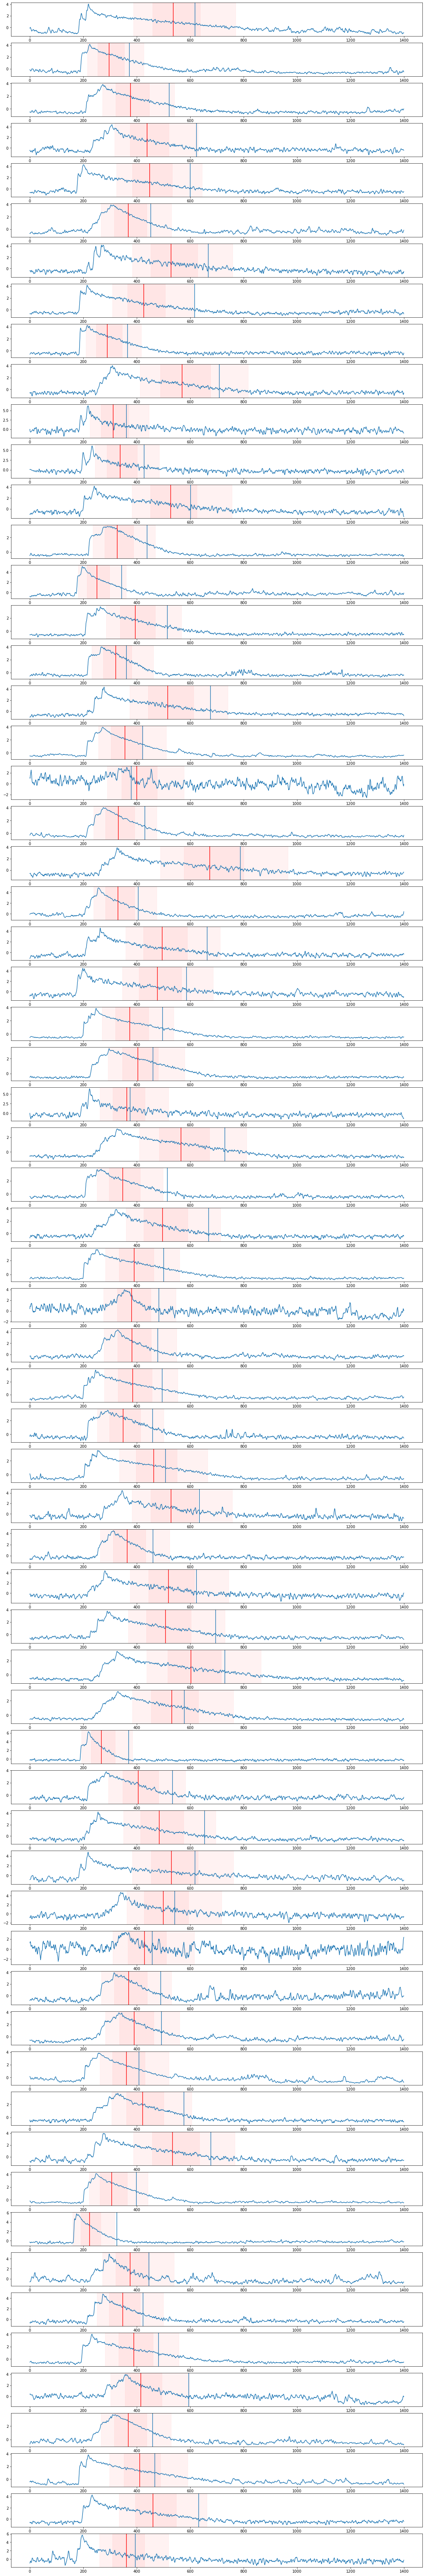

In [107]:
# plot some waveforms 
Y_pred = model.predict(tst_dat)
nb_plot = params.bs
fig, ax = plt.subplots(nb_plot, 1, figsize=(20,nb_plot*2))
for i in range(nb_plot):
    ax[i].plot(tst_dat[i])
    ax[i].axvline(tst_cat.finish.values[i])
    ax[i].axvline(Y_pred[0][i], c='red')
    ax[i].axvspan(Y_pred[1][i][0], Y_pred[4][i][0], color='red', alpha=0.05)
    ax[i].axvspan(Y_pred[2][i][0], Y_pred[3][i][0], color='red', alpha=0.05)
    
plt.savefig('images/arrnet_example.png')